# Prosper Loan data exploration phase
## by Islam Bakry Mohyee

## Investigation Overview

The goal of this presentation is to visualize the patterns and relations in the Prosper Loan dataset.

## Dataset Overview

This data set contains 113,937 loans with 81 variables on each loan, including loan amount, borrower rate (or interest rate), current loan status, borrower income, and many others.  

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from pandas.api.types import CategoricalDtype

%matplotlib inline

In [2]:
data_file = './data/prosperLoanData.csv'
def_file = './data/Prosper Loan Data - Variable Definitions.xlsx'
df = pd.read_csv(data_file)
def_df = pd.read_excel(def_file)

### The main feature of interest in the dataset:

The main feature of interest in the dataset is the **loan status** that represents the current state of the loan whether:  
- Performing.
- In default ['Chargedoff', 'Defaulted', 'Past Due','Past Due (91-120 days)', 'Past Due (>120 days)']
- Days Past Due [DPD<=90]

### Features in the dataset that may help support the investigation into the feature of interest:
As a risk analyst, I am interested in factors that can help predict the default status of loans:
    These factors are mainly: Score/Rating given by prosper (represented by multiple columns), income(stated income and income range), residential status, employment (status and duration), borrower rate.  
  
But in this presentation we will focus on our main feature of interest (LoanStatus) along with only two other two features, the Credit Score Range and the Borrower annual percentage rate.

In [3]:
df_clean = df.copy()

In [4]:
keep_columns = def_df.query('used == "imp"').index
df_clean = df_clean.iloc[:,keep_columns]
df_clean.columns

Index(['CreditGrade', 'LoanStatus', 'BorrowerAPR', 'ProsperRating (numeric)',
       'ProsperRating (Alpha)', 'ProsperScore', 'Occupation',
       'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
       'CreditScoreRangeLower', 'CreditScoreRangeUpper', 'DebtToIncomeRatio',
       'IncomeRange', 'IncomeVerifiable', 'StatedMonthlyIncome',
       'LoanOriginalAmount'],
      dtype='object')

## Univariate Exploration


In this section we inspect the distribution of our variables

**Define the main variable of interest (Performing/ Days Past Due/ Non-performing)**

In [5]:
#Drop Cancelled from the analysis because it provides no info
cancelled = df_clean.query('LoanStatus == "Cancelled"').index
df_clean = df_clean.drop(index=cancelled)

In [6]:
#NPL -> 'Chargedoff', 'Defaulted','Past Due (91-120 days)', 'Past Due (>120 days)'
#Performing -> 'Current', 'Completed', 'FinalPaymenInProgress'
#DaysPastDue(DPD) -> 'Past Due (1-15 days)','Past Due (16-30 days)','Past Due (31-60 days)','Past Due (61-90 days)'

NPL = ['Chargedoff', 'Defaulted','Past Due (91-120 days)', 'Past Due (>120 days)']
DPD = ['Past Due (1-15 days)','Past Due (16-30 days)','Past Due (31-60 days)','Past Due (61-90 days)']

In [7]:
def npl(x):
    if x in NPL:
        x = 'NPL'
    elif x in DPD:
        x = 'DPD'
    else:
        x = 'PL'
    return x

In [8]:
npl_type = CategoricalDtype(categories=['PL','NPL','DPD'], ordered=True)
df_clean['NPL'] = df_clean.LoanStatus.apply(npl).astype(npl_type)

First we made a transformation on the LoanStatus variable to focus only on the categories of interest from a risk prespective.
- all statuses that indicate a non performing loan was grouped under the category NPL (including the ones with DPD of 90+)
- statuses that indicate performing loans were grouped under the category PL
- the ones with DPD (from 1 day up to 90 days) are in the DPD group

**Check the distribution of NPL**

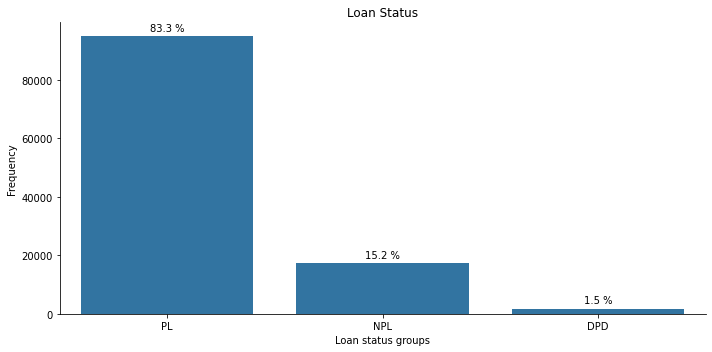

In [41]:
#check the distribution of our main variable of interest and plot percentages on bars
plt.figure(figsize=[10, 5])
color_blue = sb.color_palette()[0]
sb.countplot(data = df_clean, x = 'NPL', color = color_blue)
plt.title('Loan Status')
plt.xlabel('Loan status groups'),plt.ylabel('Frequency')
sb.despine()
types = df_clean.NPL.value_counts()
for i in range(types.shape[0]):
    type_count = types[i]
    pct = 100*type_count/df_clean.NPL.count()
    pct_string = f'{pct:0.1f} %'
    plt.text(i, type_count+4500, pct_string, ha='center', va='top')

plt.tight_layout();

We can see that most prosper's customers are performing, but about 15% are nonperforming which is high as a credit risk standard.  
  
During further analysis we will drop the DPD category as it's not needed in our scope.

In [10]:
#create dataframe for analysis after variable transformations
df_analysis = pd.DataFrame()

In [11]:
#we will drop the DPD category as it's not needed in the scope of our analysis and add the variable to new df
npl_type = CategoricalDtype(categories=['PL','NPL'], ordered=True)
df_analysis['NPL'] = df_clean.query('NPL != "DPD"')['NPL'].astype(npl_type)

**Borrower APR**

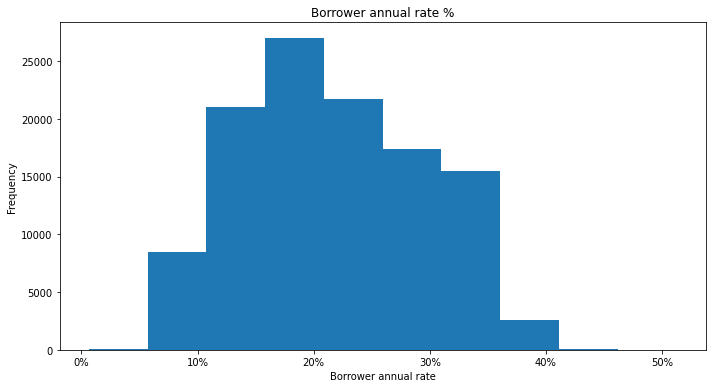

In [12]:
plt.figure(figsize=[10, 5.5])

df_clean.BorrowerAPR.plot.hist()
ticks = plt.xticks()[0][1:-1]
plt.xticks(ticks,labels=[f'{x*100:.0f}%' for x in ticks])
plt.xlabel('Borrower annual rate')
plt.title('Borrower annual rate %')
plt.tight_layout();

From the get go we get a well defined distribution with a peak at about 20% and a slight skew to the right.

In [13]:
df_analysis = df_analysis.join(df['BorrowerAPR'],how='inner')

**Credit Score Range**  
This variable describes the upper and lower bound of Credit Score range assigned by external rating agency.

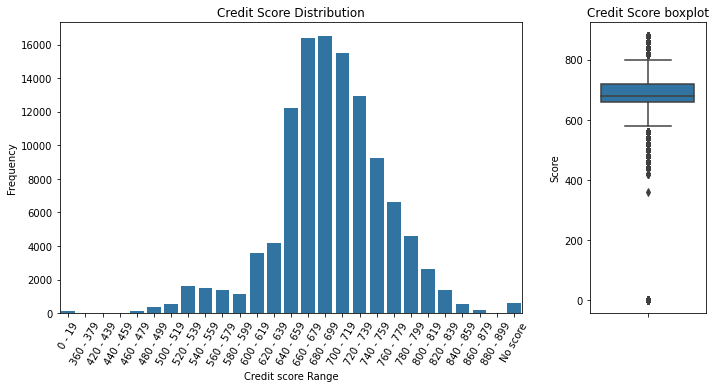

In [14]:
x = df_clean.CreditScoreRangeLower.apply(lambda x: str(x).split('.')[0])
y = df_clean.CreditScoreRangeUpper.apply(lambda x: str(x).split('.')[0])
z = x + ' - ' + y
z.loc[(z == 'nan - nan')] = 'No score'
z_order = z.value_counts().sort_index().index

f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},
                             figsize=[10, 5.5],
                             tight_layout={'w_pad':2})

sb.countplot(ax=ax1, x=z, order=z_order,color=color_blue)
ax1.tick_params(axis='x', labelrotation=60)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Credit score Range')
ax1.set_title('Credit Score Distribution');

sb.boxplot(ax=ax2,data=df_clean, y='CreditScoreRangeLower')
ax2.set_ylabel('Score')
ax2.set_title('Credit Score boxplot');

the countplot shows a nice distribution chart but appears to have tails to the right and left,  
using a boxplot to check for outliers visually, the points outside the whiskers can be considered outliers.

We will drop the outliers and have a look at both charts again.

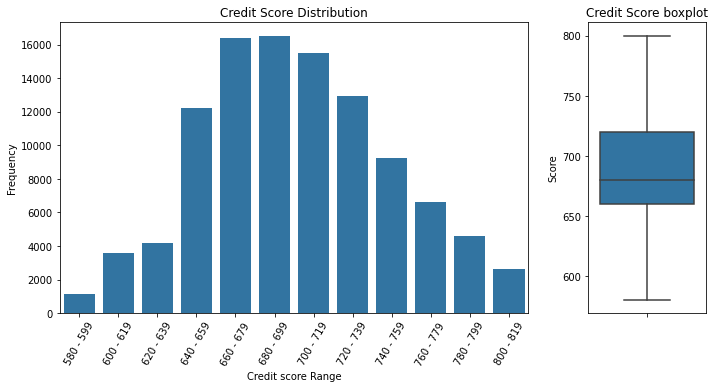

In [15]:
temp = df_clean.query('CreditScoreRangeLower > 560 and CreditScoreRangeLower < 820 ')
x = temp.CreditScoreRangeLower.apply(lambda x: str(x).split('.')[0])
y = temp.CreditScoreRangeUpper.apply(lambda x: str(x).split('.')[0])
z = x + ' - ' + y
z.loc[(z == 'nan - nan')] = 'No score'
z_order = z.value_counts().sort_index().index


f, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [4, 1]},
                             figsize=[10, 5.5],
                             tight_layout={'w_pad':2})


sb.countplot(ax=ax1, x=z, order=z_order,color=color_blue)
ax1.tick_params(axis='x', labelrotation=60)
ax1.set_ylabel('Frequency')
ax1.set_xlabel('Credit score Range')
ax1.set_title('Credit Score Distribution');

sb.boxplot(ax=ax2, data=temp, y='CreditScoreRangeLower')
ax2.set_ylabel('Score')
ax2.set_title('Credit Score boxplot');

The points with no rating were dropped and by examining the box plot we also dropped the outlier values.  
The remaining points had a fairly normal distribution with the center around the 700 score.

In [16]:
score_type = CategoricalDtype(categories=z_order , ordered=True)

In [17]:
z.rename('CreditScoreRange', inplace=True)
df_analysis = df_analysis.join(z.astype(score_type), how='inner')

### Summary of Univariate Analysis

**LoanStatus**  
First we made a transformation on the LoanStatus variable to focus only on the categories of interest from a risk prespective.  
<li>all statuses that indicate a non performing loan was grouped under the category NPL (including the ones with DPD of 90+)
<li>statuses that indicate performing loans were grouped under the category PL
<li>the ones with DPD (from 1 day up to 90 days) are in the DPD group

We can see that most prosper's customers are performing, but about 15% are nonperforming which is high as a credit risk standard. 

During further analysis we will drop the DPD category as it's not needed in our scope

**Borrower Annual percentage rate (APR)**  
From the get go we get a well defined distribution with a peak at about 20% and a slight skew to the right.

**Credit Score Range**  
The variable indicates the credit score by a consumer rating agency, the upper and lower columns were merged to form a categorical range variable.  
the points with no rating were dropped and by examining the box plot we also dropped the outlier values.  
The remaining points had a fairly normal distribution with the center around the 700 score.

## Bivariate Exploration

In this section we take a look at the relation between our selected variables and our variable of interest (NPL).

In [18]:
#create code columns for categorical variables to allow for calculating correlation
for var in df_analysis.columns:
    if df_analysis[var].dtype.name == 'category':
        df_analysis[f'{var}_codes'] = df_analysis[var].cat.codes

In [19]:
NPL_corr = df_analysis.corr()['NPL_codes']

**Borrower Annual percentage rate (APR)**

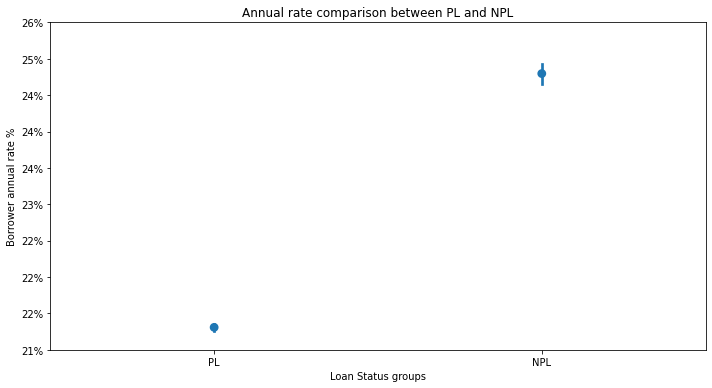

In [20]:
plt.figure(figsize=[10, 5.5])
sb.pointplot(data=df_analysis, x='NPL', y='BorrowerAPR', color=color_blue, join=False)
ticks = plt.yticks()[0]
plt.yticks(ticks,labels=[f'{x*100:.0f}%' for x in ticks])
plt.xlabel('Loan Status groups')
plt.ylabel('Borrower annual rate %')
plt.title('Annual rate comparison between PL and NPL')
plt.tight_layout();

We can see from the chart that the annual rate is higher for customers in the NPL group due to them being rated in higher risk which entails higher rates.

**Credit Score Range**

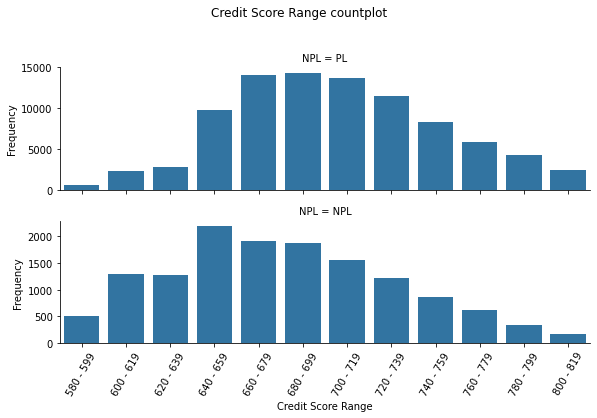

In [34]:
(sb.catplot(data=df_analysis, x='CreditScoreRange', col='NPL', kind='count', col_wrap=1,
           color=color_blue,sharey=False, height=2.8, aspect=3)
 .set_axis_labels('Credit Score Range', 'Frequency'))
plt.suptitle('Credit Score Range countplot', y=1.03)
plt.xticks(rotation=60)
plt.tight_layout();

The Credit Score Range is obtained from external rating agencies and shows a weak relation with the NPL status of the loan.

### Summary of Bivariate Analysis

- The annual rate is higher for customers in the NPL group due to them being rated in higher risk which entails higher rates

- Credit Score Range is obtained from external rating agencies and shows a weak relation with the NPL status of the 

## Multivariate Analysis

In this section we visualize the relation between three variables together

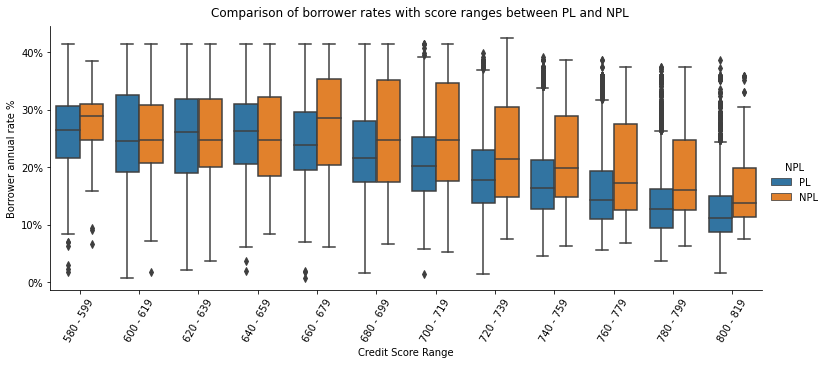

In [30]:
(sb.catplot(data=df_analysis, hue='NPL', y='BorrowerAPR', x='CreditScoreRange', kind='box',
            sharey=True, height=4.2, aspect=2.5,
           )
 .set_axis_labels('Credit Score Range','Borrower annual rate %')
)
plt.suptitle('Comparison of borrower rates with score ranges between PL and NPL', y=1.03)
plt.xticks(rotation=60)
ticks = plt.yticks()[0][1:-1]
plt.yticks(ticks,labels=[f'{x*100:.0f}%' for x in ticks])
plt.show()

**The relation between <u>Score ranges</u> and the <u>charged annual rate</u> across the categories of <u>PL and NPL</u> (our variable of interest).**  
<li>It shows how customers with higher scores are generally charged lower annual rates.  
<li>Within each score range, the ones who are performing (PL) are charged rates lower than those who are NPL (as shown by the median of each box) especially in the higher score categories